# __TASK #1__

__В данном задании вам нужно будет:__
1) проанализировать АБ  тест,  проведенный на реальных пользователях Яндекса  
2) подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control)  и тестовой (exp)  группами  
3) определить характер этих изменений и практическую значимость вводимого изменения  
4) понять, какая из пользовательских групп более всего проигрывает / выигрывает   от тестируемого изменения (локализовать изменение)  

__Описание  данных:__  
a) userID:  уникальный идентификатор пользователя  
b) browser:  браузер, который использовал userID  
c) slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control  = видел неизменную страницу)  
e) n_clicks: количество кликов, которые пользоваль совершил за n_queries  
d) n_queries: количество запросов, который совершил userID, пользуясь браузером browser  
f) n_nonclk_queries: количество запросов пользователя, в которых  им не было совершено ни одного клика  

__Обращаем ваше внимание__, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных  уникальным является сочетание userID и browser.

In [23]:
from __future__ import division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [24]:
ya_data = pd.read_csv("ab_browser_test.csv", delimiter=',')
ya_data

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30
...,...,...,...,...,...,...
566129,603133,Browser #14,control,1,2,1
566130,603134,Browser #2,exp,4,2,0
566131,603135,Browser #4,control,0,1,1
566132,603136,Browser #4,control,2,3,1


Как видно из общей сводки, данные в графе userID имеют значения, отличающиеся от их порядкового номера.
Данные признака browser и slot имеют категориальный (номинативный) характер, все остальные данные - количественные

In [25]:
ya_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566134 entries, 0 to 566133
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   userID            566134 non-null  int64 
 1   browser           566134 non-null  object
 2   slot              566134 non-null  object
 3   n_clicks          566134 non-null  int64 
 4   n_queries         566134 non-null  int64 
 5   n_nonclk_queries  566134 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 25.9+ MB


In [26]:
ya_data.isnull().any()

userID              False
browser             False
slot                False
n_clicks            False
n_queries           False
n_nonclk_queries    False
dtype: bool

Как видно, __пропущенных значений нет__, поэтому не требуется внесения изменения или заполнения пропусков в данных

In [27]:
ya_data.describe()

,userID,n_clicks,n_queries,n_nonclk_queries
count,566134.000000,566134.000000,566134.000000,566134.000000
mean,301377.214027,11.431658,10.720524,4.703987
std,175526.333101,20.251494,16.262827,8.109958
min,1.000000,0.000000,1.000000,0.000000
25%,148627.250000,1.000000,2.000000,1.000000
50%,299362.500000,4.000000,5.000000,2.000000
75%,455698.750000,13.000000,13.000000,6.000000
max,603137.000000,863.000000,665.000000,581.000000


In [28]:
#transform 'browser' column to int
ya_data.browser = [int(ya_data.browser[i][9:]) for i in range(ya_data.shape[0])]
ya_data

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,2,exp,23,32,19
1,3,4,exp,3,4,2
2,5,4,exp,29,35,16
3,6,4,control,12,6,0
4,7,4,exp,54,68,30
...,...,...,...,...,...,...
566129,603133,14,control,1,2,1
566130,603134,2,exp,4,2,0
566131,603135,4,control,0,1,1
566132,603136,4,control,2,3,1


Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

Посчитаем, насколько в группе __exp__ больше пользовательских кликов по сравнению с группой __control__ в процентах от числа кликов в контрольной группе.

In [29]:
#number of people in exp and control groups
ya_data.slot.value_counts()

control    284554
exp        281580
Name: slot, dtype: int64

Примем в первом приближении, что количество человек в каждой из групп одинаково.

In [34]:
ya_data.index?

In [ ]:
ya_data.slot.loc[ya_data.slot == 'exp'].index

In [30]:
exp = ya_data.slot.loc[ya_data.slot == 'exp'].index
ctrl = ya_data.slot.loc[ya_data.slot == 'control'].index

In [32]:
print(exp, ctrl)

Int64Index([     0,      1,      2,      4,      6,      8,     10,     11,
                12,     14,
            ...
            566103, 566104, 566108, 566116, 566123, 566125, 566126, 566127,
            566130, 566133],
           dtype='int64', length=281580) Int64Index([     3,      5,      7,      9,     13,     15,     19,     22,
                24,     25,
            ...
            566118, 566119, 566120, 566121, 566122, 566124, 566128, 566129,
            566131, 566132],
           dtype='int64', length=284554)


In [36]:
#assumption error
err = (1 - ya_data.slot.loc[exp].shape[0] / ya_data.slot.loc[ctrl].shape[0]) * 100
print('Assumption error: %.4f' % err + "%")

Assumption error: 1.0451%


Будем считать, что ошибка в предположении __менее 5%__ позволительна для получения адекватных объективных результатов

In [37]:
exp_cl_num = ya_data.n_clicks.loc[exp].sum()
ctrl_cl_num = ya_data.n_clicks.loc[ctrl].sum()

print('Total number of clicks in each group')
print('Exp: %d' % exp_cl_num)
print('Control: %d' % ctrl_cl_num)

Total number of clicks in each group
Exp: 3261823
Control: 3210027


In [38]:
#proportion increase of clicks for exp over control
prop_inc_clicks = (exp_cl_num / ctrl_cl_num - 1) * 100
print('Proportion increase of clicks for exp over control: %.3f%%' % prop_inc_clicks)

Proportion increase of clicks for exp over control: 1.614%


Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого построим с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп.

In [39]:
#Clicks mean values
exp_cl_mean = ya_data.n_clicks.loc[exp].mean()
ctrl_cl_mean = ya_data.n_clicks.loc[ctrl].mean()
print('Mean number of clicks in each group')
print('Exp: %.4f' % exp_cl_mean)
print('Control: %.4f' % ctrl_cl_mean)
print('')

#Clicks median values
exp_cl_mean = ya_data.n_clicks.loc[exp].median()
ctrl_cl_mean = ya_data.n_clicks.loc[ctrl].median()
print('Median number of clicks in each group')
print('Exp: %d' % exp_cl_mean)
print('Control: %d' % ctrl_cl_mean)

Mean number of clicks in each group
Exp: 11.5840
Control: 11.2809

Median number of clicks in each group
Exp: 5
Control: 4


In [41]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [42]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [43]:
%%time
#confidence intervals estimation
np.random.seed(0)

num_of_samples = 500

exp_cl_mean, ctrl_cl_mean = np.empty(num_of_samples), np.empty(num_of_samples)
exp_cl_median, ctrl_cl_median = np.empty(num_of_samples), np.empty(num_of_samples)

ctrl_cl_var = np.empty(num_of_samples)

exp_data = get_bootstrap_samples(ya_data.n_clicks.loc[exp].values, num_of_samples)
ctrl_data = get_bootstrap_samples(ya_data.n_clicks.loc[ctrl].values, num_of_samples)

for i in range(num_of_samples):
    exp_cl_mean[i], ctrl_cl_mean[i] = exp_data[i].mean(), ctrl_data[i].mean() 
    exp_cl_median[i], ctrl_cl_median[i] = np.median(exp_data[i]), np.median(ctrl_data[i])
    
    ctrl_cl_var[i] = ctrl_data[i].var()

CPU times: user 9.01 s, sys: 400 ms, total: 9.41 s
Wall time: 9.4 s


In [45]:
delta_mean = list(map(lambda x: x[0] - x[1], zip(exp_cl_mean, ctrl_cl_mean)))
delta_median = list(map(lambda x: x[0] - x[1], zip(exp_cl_median, ctrl_cl_median)))

delta_mean_bnd = stat_intervals(delta_mean, 0.05)
delta_median_bnd = stat_intervals(delta_median, 0.05)

print('Conf. int. delta mean: [%.4f, %.4f]' % (delta_mean_bnd[0], delta_mean_bnd[1]))
print('Conf. int. delta median: [%d, %d]' % (delta_median_bnd[0], delta_median_bnd[1]))
print('legend: diff = exp - control')

Conf. int. delta mean: [0.1996, 0.4050]
Conf. int. delta median: [1, 1]
legend: diff = exp - control


Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

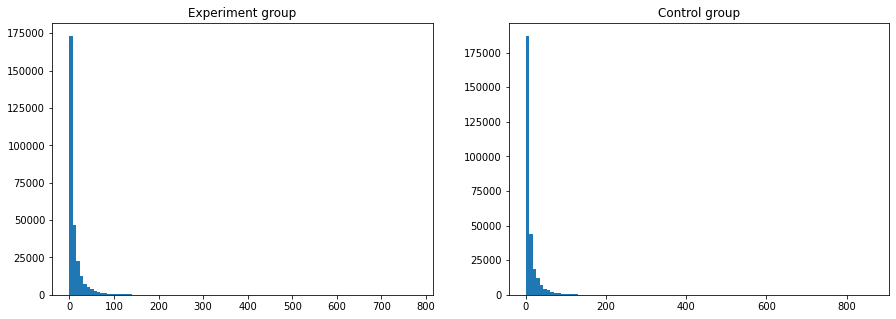

In [47]:
_ = plt.figure(figsize=(15,5))
_ = plt.subplot(121)
_ = plt.hist(ya_data.n_clicks.loc[exp], bins=100)
_ = plt.title('Experiment group')
_ = plt.subplot(122)
_ = plt.hist(ya_data.n_clicks.loc[ctrl], bins=100)
_ = plt.title('Control group')

__t-критерий Стьюдента__ имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

Для простоты рассмотрим одновыборочный t-критерий. Чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:

1) среднее значение в выборке было распределено нормально N(μ,σ2n)  
2) несмещенная оценка дисперсии c масштабирующим коэффициентом была распределена по хи-квадрат c n−1 степенями свободы χ2(n−1)  

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными в рамках данного вопроса.  
Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия.

Для этого

1) получим из данных n_boot_samples псевдовыборок.  
2) по каждой из этих выборок посчитаем среднее и сумму квадратов отклонения от выборочного среднего  
3) для получившегося вектора средних значений из n_boot_samples построим q-q plot с помощью scipy.stats.probplot для нормального распределения  
4) для получившегося вектора сумм квадратов отклонения от выборочного среднего построим qq-plot с помощью scipy.stats.probplot для хи-квадрат распределения  

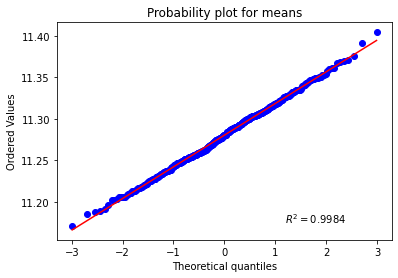

In [48]:
#probability plot for means
_ = stats.probplot(ctrl_cl_mean, plot=plt, rvalue=True)
_ = plt.title('Probability plot for means')

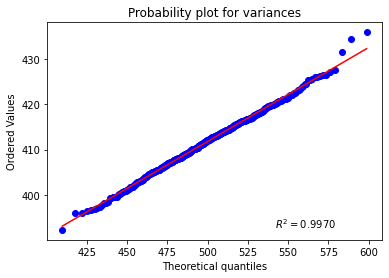

In [49]:
#probability plot for variances
_ = stats.probplot(ctrl_cl_var, plot=plt, dist='chi2', sparams=(ctrl_cl_mean.shape[0]-1), rvalue=True)
_ = plt.title('Probability plot for variances')

Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделим выборку на две части, соответствующие control и exp группам. Преобразуем данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверим гипотезу о равенстве средних.

In [51]:
users_nclicks_exp = ya_data.loc[exp].groupby(['userID', 'browser']).sum().loc[:,'n_clicks']
users_nclicks_ctrl = ya_data.loc[ctrl].groupby(['userID', 'browser']).sum().loc[:,'n_clicks']

users_nclicks_exp.head()
users_nclicks_ctrl.head()

userID  browser
1       2          23
3       4           3
5       4          29
7       4          54
9       4           6
Name: n_clicks, dtype: int64

userID  browser
6       4          12
8       4           4
10      4          22
15      14          2
23      4           3
Name: n_clicks, dtype: int64

In [52]:
stats.mannwhitneyu(users_nclicks_exp, users_nclicks_ctrl, alternative='two-sided')

MannwhitneyuResult(statistic=41184125116.0, pvalue=6.247235801369629e-75)

Проверим, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого применим для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделаем поправку Холма-Бонферрони на множественную проверку с α=0.05.

In [53]:
browsers_nclicks_exp = ya_data.loc[exp].groupby(['browser', 'userID']).sum().loc[:,'n_clicks']
browsers_nclicks_ctrl = ya_data.loc[ctrl].groupby(['browser', 'userID']).sum().loc[:,'n_clicks']

browsers_nclicks_exp.head()
browsers_nclicks_ctrl.head()

browser  userID
2        1         23
         31         7
         38        39
         41        32
         46         4
Name: n_clicks, dtype: int64

browser  userID
2        29         9
         32         3
         60         5
         70         5
         73        13
Name: n_clicks, dtype: int64

In [56]:
#Unique browsers
browsers = np.unique(ya_data.browser)
print('Unique browsers numbers: ' + str(browsers))
print('')

print('Mann-Whitney rank test without multipletest')
mw_p = np.empty(browsers.shape[0])
for i, br in enumerate(browsers):
    print('Browser #%d: ' % br),
    _, mw_p[i] = stats.mannwhitneyu(browsers_nclicks_exp.loc[br, :], browsers_nclicks_ctrl.loc[br, :], alternative='two-sided')
    print('p-value = %.4f' % mw_p[i])

print('')
print('Mann-Whitney rank test with multipletest')
_, mw_p_corr, _, _ = multipletests(mw_p, alpha = 0.05, method = 'holm')
for i, br in enumerate(browsers):
    print('Browser #%d: ' % br),
    print('p-value = %.4f' % mw_p_corr[i])

Unique browsers numbers: [ 2  4 14 17 20 22]

Mann-Whitney rank test without multipletest
Browser #2: 


(None,)

p-value = 0.0545
Browser #4: 


(None,)

p-value = 0.8152
Browser #14: 


(None,)

p-value = 0.0000
Browser #17: 


(None,)

p-value = 0.0748
Browser #20: 


(None,)

p-value = 0.9073
Browser #22: 


(None,)

p-value = 0.5148

Mann-Whitney rank test with multipletest
Browser #2: 


(None,)

p-value = 0.2724
Browser #4: 


(None,)

p-value = 1.0000
Browser #14: 


(None,)

p-value = 0.0000
Browser #17: 


(None,)

p-value = 0.2992
Browser #20: 


(None,)

p-value = 1.0000
Browser #22: 


(None,)

p-value = 1.0000


Для каждого браузера в каждой из двух групп (control и exp) посчитаем долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

In [57]:
browsers_nonclk_q_exp = ya_data.loc[exp].groupby(['browser']).sum().loc[:,'n_nonclk_queries']
browsers_clk_q_exp = ya_data.loc[exp].groupby(['browser']).sum().loc[:,'n_queries']
browsers_nonclk_q_prop_exp = browsers_nonclk_q_exp / browsers_clk_q_exp

browsers_nonclk_q_ctrl = ya_data.loc[ctrl].groupby(['browser']).sum().loc[:,'n_nonclk_queries']
browsers_clk_q_ctrl = ya_data.loc[ctrl].groupby(['browser']).sum().loc[:,'n_queries']
browsers_nonclk_q_prop_ctrl = browsers_nonclk_q_ctrl / browsers_clk_q_ctrl

print('Control / experimental groups')
for br in browsers:
    print('Browser #%d' % br),
    print(browsers_nonclk_q_prop_ctrl.loc[browsers_nonclk_q_prop_ctrl.index == br].values),
    print('/'),
    print(browsers_nonclk_q_prop_exp.loc[browsers_nonclk_q_prop_ctrl.index == br].values)

Control / experimental groups
Browser #2


(None,)

[0.45962747]


(None,)

/


(None,)

[0.44982747]
Browser #4


(None,)

[0.4697093]


(None,)

/


(None,)

[0.45142942]
Browser #14


(None,)

[0.57590411]


(None,)

/


(None,)

[0.43755617]
Browser #17


(None,)

[0.36299367]


(None,)

/


(None,)

[0.36937413]
Browser #20


(None,)

[0.40540485]


(None,)

/


(None,)

[0.38977376]
Browser #22


(None,)

[0.40593977]


(None,)

/


(None,)

[0.39853947]
